# **Saliency Maps**

Here I adapt the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) Class Activation Map ungraded lab and make it generate saliency maps instead.

a saliency map shows the pixels which greatly impacts the classification of an image. 
- This is done by getting the gradient of the loss with respect to changes in the pixel values, then plotting the results. 
- From there, I can see if my model is looking at the correct features when classifying an image. 
  - For example, if I'm building a dog breed classifier, I should be wary if my saliency map shows strong pixels outside the dog itself (e.g. sky, grass, dog house, etc...).




### Download test files and weights

In [1]:
# Download the same test files from the Cats vs Dogs ungraded lab
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

# Download prepared weights
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kipXTxesGJKGY1B8uSPRvxROgOH90fih' -O 0_epochs.h5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oiV6tjy5k7h9OHGTQaf0Ohn3FmF-uOs1' -O 15_epochs.h5


--2025-08-16 15:14:46--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.184.219, 172.217.18.27, 172.217.16.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.184.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.1s    

2025-08-16 15:14:46 (3.44 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2025-08-16 15:14:47--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.184.219, 172.217.18.27, 172.217.16.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.184.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving t

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

### Download and prepare the dataset.

#### Load Cats vs Dogs 

* Required: Use Tensorflow Datasets to fetch the `cats_vs_dogs` dataset. 
  * Use the first 80% of the *train* split of the said dataset to create your training set.
  * Set the `as_supervised` flag to create `(image, label)` pairs.
    
* I create validation and test sets from the remaining 10% of the *train* split of `cats_vs_dogs`.

In [3]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

2025-08-16 15:34:46.729484: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-08-16 15:34:46.729511: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-08-16 15:34:46.729517: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-08-16 15:34:46.729534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-16 15:34:46.729543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Create preprocessing function

Define a function that takes in an image and label. This:
  * cast the image to float32
  * normalize the pixel values to [0, 1]
  * resize the image to 300 x 300


In [4]:
def augmentimages(image, label):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label



#### Preprocess the training set

Use the `map()` and pass in the method that I just defined to preprocess the training set.


In [5]:
# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augmentimages)


#### Create batches of the training set. 

Normally, I will want to shuffle the training set. But for predictability in the grading, I will simply create the batches.

```Python
# Shuffle the data if I'm working on my own personal project 
train_batches = augmented_training_data.shuffle(1024).batch(32)
```

In [6]:

train_batches = augmented_training_data.batch(32)

### Build the Cats vs Dogs classifier 

* I modify the Cats vs Dogs model at the last dense layer to output 2 neurons instead of 1. 
  - This is because I adapt the `do_salience()` function from the lab and that works with one-hot encoded labels. 
  - I do this by changing the `units` argument of the output Dense layer from 1 to 2, with one for each of the classes (i.e. cats and dogs).
  - I choose an activation that outputs a probability for each of the 2 classes (i.e. categories), where the sum of the probabilities adds up to 1.

In [ ]:

model = Sequential([
    keras.Input(shape=(300, 300, 3)),
    Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),

    # CHANGED: from Dense(1, activation='sigmoid') -> Dense(2, activation='softmax')
    Dense(2, activation='softmax')
])


model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,698 (381.63 KB)

 Trainable params: 97,698 (381.63 KB)

 Non-trainable params: 0 (0.00 B)

### Create a function to generate the saliency map


In [22]:


def do_salience(image, model, label, prefix):
  '''
  Generates the saliency map of a given image.

  Args:
    image (str) -- filename/path of the picture that the model will classify
    model (keras Model) -- your cats and dogs classifier (2-class softmax)
    label (int) -- ground truth label of the image (0 or 1)
    prefix (string) -- prefix to add to the filename of the saliency map
  '''

  # --- Read the image and convert channel order from BGR to RGB ---
  bgr = cv2.imread(image)                            # shape: (H, W, 3), BGR uint8
  rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)         # to RGB

  # --- Resize the image to 300 x 300 and normalize pixel values to [0, 1] ---
  rgb_300 = cv2.resize(rgb, (300, 300), interpolation=cv2.INTER_AREA)
  rgb_300 = rgb_300.astype(np.float32) / 255.0       # float32 in [0,1]

  # --- Add batch dimension ---
  x = tf.convert_to_tensor(rgb_300)[tf.newaxis, ...] # shape: (1, 300, 300, 3)

  # --- Declare number of classes ---
  num_classes = 2

  # --- One-hot encode the label ---
  y_true = tf.one_hot(label, depth=num_classes)      # shape: (2,)
  y_true = y_true[tf.newaxis, ...]                   # shape: (1, 2)

  # --- Compute loss under GradientTape ---
  with tf.GradientTape() as tape:
    x_float = tf.cast(x, tf.float32)
    tape.watch(x_float)
    preds = model(x_float, training=False)           # shape: (1, 2), softmax
    # Uncomment to inspect: print("preds:", preds.numpy(), "sum:", tf.reduce_sum(preds).numpy())
    loss = tf.keras.losses.categorical_crossentropy(y_true, preds)

  # --- Gradients of loss w.r.t. input image ---
  grads = tape.gradient(loss, x_float)               # shape: (1, 300, 300, 3)

  # --- Generate grayscale tensor (take max magnitude across channels) ---
  grads_abs = tf.math.abs(grads)
  grayscale = tf.reduce_max(grads_abs, axis=-1, keepdims=True)  # (1, 300, 300, 1)

  # --- Normalize to [0, 255] and cast to uint8 ---
  # 255 * (x - min) / (max - min + epsilon)
  g_min = tf.reduce_min(grayscale)
  g_max = tf.reduce_max(grayscale)
  eps = tf.constant(1e-12, dtype=grayscale.dtype)
  normalized = 255.0 * (grayscale - g_min) / (g_max - g_min + eps)
  normalized = tf.cast(normalized, tf.uint8)         # (1, 300, 300, 1)

  # --- Remove size-1 dimensions ---
  normalized_tensor = tf.squeeze(normalized, axis=0) # -> (300, 300, 1)

  # --- Plot the normalized tensor ---
  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(tf.squeeze(normalized_tensor, axis=-1), cmap='gray')
  plt.show()

  # --- Optional: superimpose saliency with original image (for visualization) ---
  try:
    heatmap = tf.squeeze(normalized_tensor, axis=-1).numpy().astype(np.float32)
    heatmap = cv2.applyColorMap(heatmap.astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(rgb_300, 0.6, heatmap / 255.0, 0.4, 0.0)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(overlay)
    plt.title('Overlay (optional)')
    plt.show()
  except Exception as e:
    # Keep the core pipeline robust even if OpenCV colormap isn't available
    pass

  # --- Save the normalized tensor image to a file (grayscale JPEG) ---
  salient_image_name = prefix + image
  to_save = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
  _ = tf.io.write_file(salient_image_name, to_save)


### Generate saliency maps with untrained model

As a sanity check, I load initialized (i.e. untrained) weights and use the function I just implemented. 
- This will check if I built the model correctly and are able to create a saliency map. 

I apply `do_salience()` function on the following image files:

* `cat1.jpg`
* `cat2.jpg`
* `catanddog.jpg`
* `dog1.jpg`
* `dog2.jpg`

Cats will have the label `0` while dogs will have the label `1`. 
- For the catanddog, I use `0`. 
- For the prefix of the salience images that will be generated, I use the prefix `epoch0_salient`.

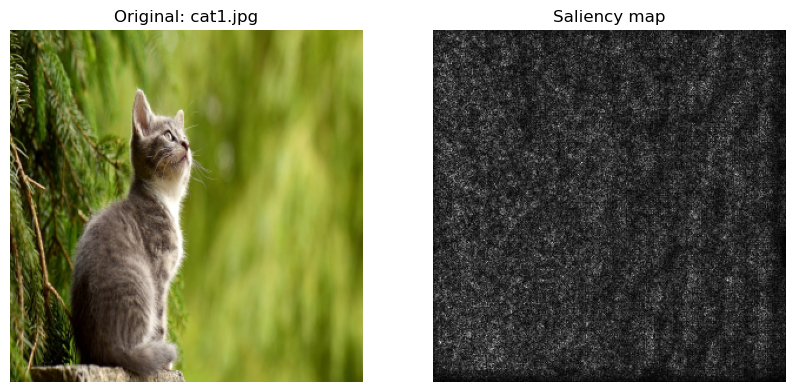

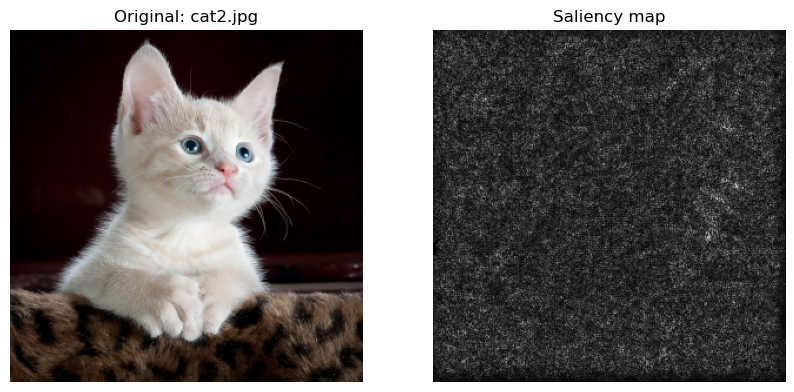

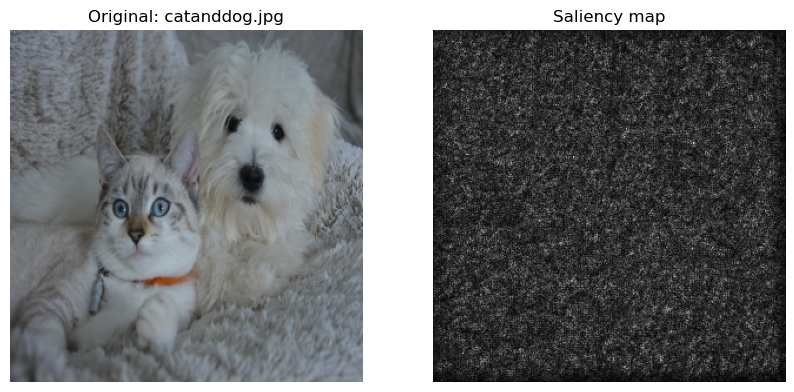

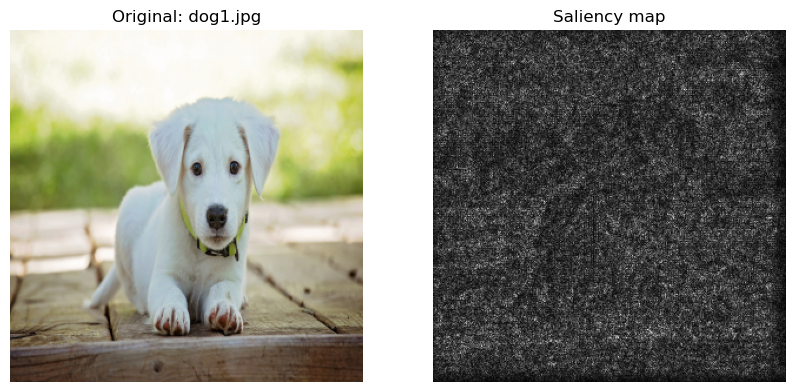

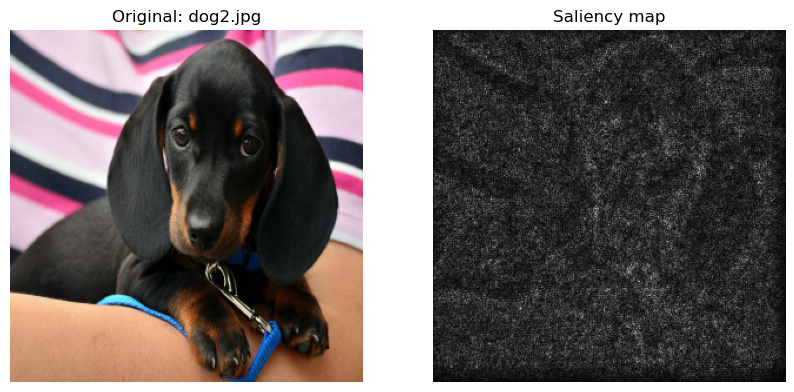

In [23]:
# --- Images + labels ---
test_cases = [
    ("cat1.jpg", 0),
    ("cat2.jpg", 0),
    ("catanddog.jpg", 0),
    ("dog1.jpg", 1),
    ("dog2.jpg", 1),
]

# --- Display original + saliency ---
for img_path, lbl in test_cases:
    orig, sal = do_salience_return(img_path, model, lbl)

    plt.figure(figsize=(10,5))

    # Original
    plt.subplot(1,2,1)
    plt.imshow(orig)
    plt.title(f"Original: {img_path}")
    plt.axis("off")

    # Saliency
    plt.subplot(1,2,2)
    plt.imshow(sal, cmap="gray")
    plt.title("Saliency map")
    plt.axis("off")
    
    plt.show()


### Configure the model for training

Use `model.compile()` to define the loss, metrics and optimizer. 

* Choose a loss function for the model to use when training. 
  - For `model.compile()` the ground truth labels from the training set are passed to the model as **integers** (i.e. 0 or 1) as opposed to one-hot encoded vectors.
  - The model predictions are class probabilities. 
  - I browsed the [tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) to determine which one is best used for this case. 
  - I pass the function as a string (e.g. `loss = 'loss_function_a'`). 

* For metrics, I measure `accuracy`. 
* For the optimizer, I use [RMSProp](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop).
  - I the default learning rate of `0.001`.

In [25]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001),   # default LR
    loss='sparse_categorical_crossentropy',   # integer labels 0/1
    metrics=['accuracy']
)


### Train your model

I pass in the training batches and train my model for just **3** epochs. 

In [29]:
model.fit(train_batches, epochs=3)


Epoch 1/3
190/582 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.5115 - loss: 0.6931

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/582 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.5105 - loss: 0.6931

233/582 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.5103 - loss: 0.6931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


303/582 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5091 - loss: 0.6932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


513/582 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5071 - loss: 0.6932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


527/582 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5070 - loss: 0.6932

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


536/582 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5070 - loss: 0.6932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


563/582 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5069 - loss: 0.6932

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


569/582 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5068 - loss: 0.6932

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.5039 - loss: 0.6933
Epoch 2/3
189/582 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.5115 - loss: 0.6930

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/582 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5106 - loss: 0.6931

233/582 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.5103 - loss: 0.6931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


303/582 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5090 - loss: 0.6931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


513/582 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5070 - loss: 0.6931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


525/582 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5069 - loss: 0.6931

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


535/582 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5069 - loss: 0.6931

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


562/582 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5068 - loss: 0.6931

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


568/582 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5068 - loss: 0.6931

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.5042 - loss: 0.6932
Epoch 3/3
190/582 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.5115 - loss: 0.6930

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/582 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5105 - loss: 0.6930

232/582 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.5103 - loss: 0.6930

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


304/582 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5090 - loss: 0.6931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


513/582 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5071 - loss: 0.6931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


525/582 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5070 - loss: 0.6931

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


535/582 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5070 - loss: 0.6931

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


563/582 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5069 - loss: 0.6931

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


569/582 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5068 - loss: 0.6931

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.5045 - loss: 0.6932


In [32]:
from zipfile import ZipFile

!rm images.zip

filenames = ['cat1.jpg', 'cat2.jpg', 'catanddog.jpg', 'dog1.jpg', 'dog2.jpg']

# writing files to a zipfile 
with ZipFile('images.zip','w') as zip:
  for file in filenames:
    zip.write('salient' + file)

print("images.zip generated!")

images.zip generated!
